- Claim, "you would like this restaurant"
- Evidence, "Cause you used to like A and B aspects" (based on the importance on aspects)
- Evidence, "Similar users also visited this restaurant"

In [1]:
import pandas as pd
import numpy as np
from collections import defaultdict
from nltk.stem.wordnet import WordNetLemmatizer
lemma = WordNetLemmatizer()

In [2]:
restaurants = pd.read_parquet('restaurants_reviews_with_aspects_polarities')
users = pd.read_parquet('users_reviews_with_aspects_polarities')

In [3]:
# duplicate the aspect polarity pair if the useful field is not 0
restaurants['aspect_polarity'] = restaurants.apply(lambda x: np.repeat(x['aspect_polarity'], x['useful']+1), axis=1)

In [4]:
# Sample 20% as test set
users_test = {};
user_ids = users['user_id'].unique();
for user_id in user_ids:
    user_df = users.groupby('user_id').get_group(user_id);
    mask_restaurants = pd.Series(user_df[user_df['stars'] >= 3]['business_id'].unique()).sample(frac=0.2, random_state=100).values;
    users_test[user_id] = mask_restaurants;

In [5]:
# Extract training set
users_train = users.copy();

for user_id in users_test:
    user = users_test[user_id];
    for restaurant_id in user:
        drop_rows = users_train[(users_train['user_id'] == user_id)&(users_train['business_id'] == restaurant_id)];
        users_train.drop(drop_rows.index, inplace=True);

In [6]:
users_visited = {};

for user_id in user_ids:
    users_visited[user_id] = users_train.groupby('user_id').get_group(user_id)['business_id'].unique();

In [7]:
def countTokens(sentences):
    tokens_list = [sentence.split(' ') for sentence in sentences]
    return sum([len(tokens) for tokens in tokens_list])

def getTestSetOf(uids):
    df = pd.DataFrame(columns=users.columns);
    for uid in uids:
        visited = users_test[uid];
        for rid in visited:
            df = pd.concat([df, users.groupby(['user_id', 'business_id']).get_group((uid, rid))]);
    return df;

user_test = getTestSetOf(users_test.keys());

# Restaurant data description
print("Total review count:", restaurants.shape[0])
print("Average review count per restaurant:", np.average(restaurants.groupby('business_id').count()['review_id']))
print("Average sentence count per review:", np.average(restaurants['text'].apply(lambda x: x.replace('\n', '').split('.')).apply(lambda x: len(x))))
print("Average tokens count per review:", np.average(restaurants['text'].apply(lambda x: x.replace('\n', '').split('.')).apply(countTokens)))

print("----------------------")

# User data description
print("Total review count:", users.shape[0])
print("Average review count per user:", np.average(users.groupby('user_id').count()['review_id']))
print("Average sentence count per review:", np.average(users['text'].apply(lambda x: x.replace('\n', '').split('.')).apply(lambda x: len(x))))
print("Average tokens count per review:", np.average(users['text'].apply(lambda x: x.replace('\n', '').split('.')).apply(countTokens)))

print("----------------------")

# Training set data description
print("Total review count:", users_train.shape[0])
print("Average review count per user:", np.average(users_train.groupby('user_id').count()['review_id']))
print("Average sentence count per review:", np.average(users_train['text'].apply(lambda x: x.replace('\n', '').split('.')).apply(lambda x: len(x))))
print("Average tokens count per review:", np.average(users_train['text'].apply(lambda x: x.replace('\n', '').split('.')).apply(countTokens)))

print("----------------------")

# Testing set data description
print("Total review count:", user_test.shape[0])
print("Average review count per user:", np.average(user_test.groupby('user_id').count()['review_id']))
print("Average sentence count per review:", np.average(user_test['text'].apply(lambda x: x.replace('\n', '').split('.')).apply(lambda x: len(x))))
print("Average tokens count per review:", np.average(user_test['text'].apply(lambda x: x.replace('\n', '').split('.')).apply(countTokens)))

Total review count: 5000
Average review count per restaurant: 50.0
Average sentence count per review: 9.2604
Average tokens count per review: 122.178
----------------------
Total review count: 3003
Average review count per user: 30.03
Average sentence count per review: 12.012321012321012
Average tokens count per review: 173.42024642024643
----------------------
Total review count: 2426
Average review count per user: 24.26
Average sentence count per review: 11.921269579554822
Average tokens count per review: 171.61046990931575
----------------------
Total review count: 577
Average review count per user: 5.77
Average sentence count per review: 12.395147313691508
Average tokens count per review: 181.02946273830156


### Compute the scores of aspects  

Format for aspect: [Overall score = POS-NEG, Positive CNT, Negative CNT, Total CNT=POS+NEG+NEUTRAL]

In [8]:
def getScore(sentiment):
    if sentiment == 'Positive':
        return 1;
    elif sentiment == 'Negative':
        return -1;
    else:
        return 0;

def lemmatizeAspect(aspect):
    tokens = [ lemma.lemmatize(lemma.lemmatize(token, pos='v'), pos='n') for token in aspect.split(' ')];
    return ' '.join(tokens);
    
def reviewAspects(dic):
    def inner(aspect_polarity_pairs):
        for pair in aspect_polarity_pairs:
            aspects, sentiments = pair['aspect'], pair['sentiment'];
            for i, aspect in enumerate(aspects):
                aspect = lemmatizeAspect(aspect);
                dic[aspect][0] += getScore(sentiments[i]);
                if sentiments[i] == 'Positive':
                    dic[aspect][1] += 1;
                if sentiments[i] == 'Negative':
                    dic[aspect][2] += 1;
                dic[aspect][3] += 1;
    return inner;

In [9]:
# Get the aspects and score of them of restaurants
restaurant_aspects = {};
for business in restaurants['business_id'].unique():
    dic = defaultdict(lambda: [0, 0, 0, 0]);
    restaurants.groupby('business_id').get_group(business)['aspect_polarity'].apply(reviewAspects(dic));
    # dic = sorted(dic.items(), key=lambda x: x[1], reverse=True);
    restaurant_aspects[business] = dic;

In [10]:
# Get the aspects and score of them of users
user_aspects = {};
for user in users_train['user_id'].unique():
    dic = defaultdict(lambda: [0, 0, 0, 0]);
    users_train.groupby('user_id').get_group(user)['aspect_polarity'].apply(reviewAspects(dic));
    # dic = sorted(dic.items(), key=lambda x: x[1], reverse=True);
    user_aspects[user] = dic;

In [11]:
REST_DICTIONARY = set();
for dic in restaurant_aspects.values():
    for key in dic:
        REST_DICTIONARY.add(key);

USER_DICTIONARY = set();
for dic in user_aspects.values():
    for key in dic:
        USER_DICTIONARY.add(key);
        
user_dictionary = list(USER_DICTIONARY);
restaurant_dictionary = list(REST_DICTIONARY);

Since the word matrix is too spacy, we have to remove some infrequent words.

In [12]:
# Aspects set of each restaurant
restaurant_aspects_set = {};
for restaurant in restaurant_aspects:
    restaurant_aspects_set[restaurant] = set(restaurant_aspects[restaurant].keys());

# Aspects set of each user
user_aspects_set = {};
for user in user_aspects:
    user_aspects_set[user] = set(user_aspects[user].keys());    
    
# Count the frequency of each aspect shown in restaurants
aspect_restaurant_freq = defaultdict(int);
for aspect in restaurant_dictionary:
    
    for restaurant in restaurant_aspects_set:
        if aspect in restaurant_aspects_set[restaurant]:
            aspect_restaurant_freq[aspect] += 1;

# Count the frequency of each aspect shown in user reviews
aspect_user_freq = defaultdict(int);
for aspect in user_dictionary:
    for user in user_aspects_set:
        if aspect in user_aspects_set[user]:
            aspect_user_freq[aspect] += 1;

In [13]:
# Remove unfrequent aspect from dictionary to reduce the size of dictionary, so the matrix will not be too sparse
user_unfreq = np.array(list(aspect_user_freq.keys()))[np.array(list(aspect_user_freq.values())) == 1];
rest_unfreq = np.array(list(aspect_restaurant_freq.keys()))[np.array(list(aspect_restaurant_freq.values())) == 1];

for aspect in user_unfreq:
    USER_DICTIONARY.remove(aspect);

for aspect in rest_unfreq:
    REST_DICTIONARY.remove(aspect);

In [14]:
DICTIONARY = REST_DICTIONARY.union(USER_DICTIONARY);

# dictionary containing all the aspects
dictionary = list(DICTIONARY);
user_dictionary = list(USER_DICTIONARY);
restaurant_dictionary = list(REST_DICTIONARY);

---
### Importance of aspects

**Concern, requirements and importance**

Caculation of concern:  
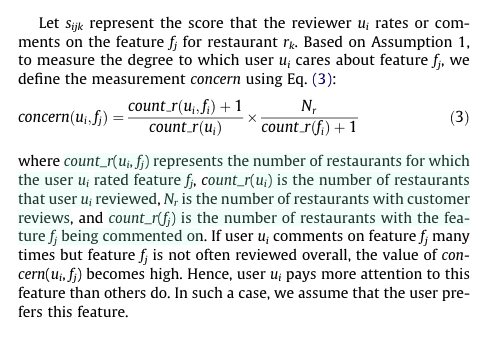

Caculation of requirement:   
NOTE: The calculation of requirements are unable to be finished, since we use the sentiment score but not rate from users.  
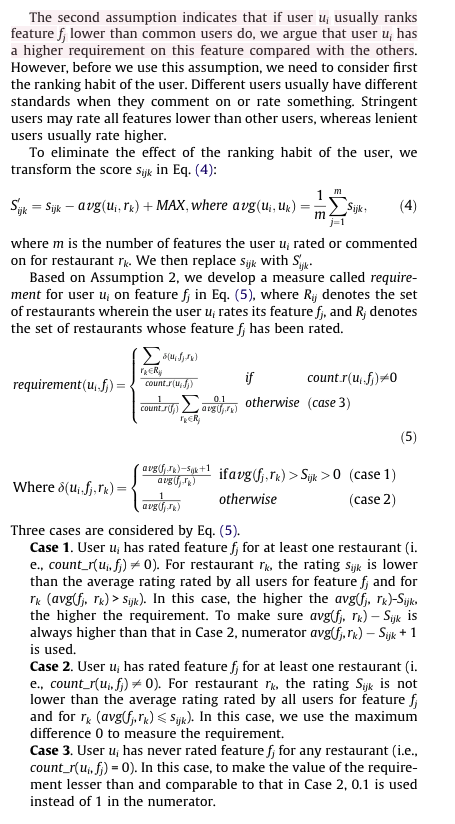

Importance  
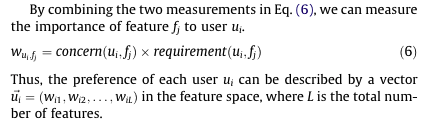

In [15]:
# Aspects set of each restaurant
restaurant_aspects_set = {};
for restaurant in restaurant_aspects:
    restaurant_aspects_set[restaurant] = set(restaurant_aspects[restaurant].keys());

# Count the frequency of each aspect shown in restaurants
aspect_restaurant_freq = defaultdict(int);
for aspect in restaurant_dictionary:
    for restaurant in restaurant_aspects_set:
        if aspect in restaurant_aspects_set[restaurant]:
            aspect_restaurant_freq[aspect] += 1;

In [16]:
user_concerns = {};
restaurants_total = restaurants['business_id'].unique().size;

for user_id in user_aspects.keys():
    user = user_aspects[user_id].copy();
    restaurants_visited = users_train.groupby('user_id').get_group(user_id)['business_id'].unique().size;
    for aspect in user:
        if aspect in restaurant_dictionary:
            user[aspect] = [((user[aspect][3]+1)/restaurants_visited)*np.log(restaurants_total/(aspect_restaurant_freq[aspect]+1)), user[aspect][3]];
        else: # if the aspect doesn't show in the restaurant_dictionary, assign 0
            user[aspect] = [0, user[aspect][3]];
        user = dict(sorted(user.items(), key=lambda x: x[1], reverse=True));
        user_concerns[user_id] = user;

In [17]:
AVG_USER_COMMENT_CNT = np.average([np.average([arr[3] for arr in user_aspects[user].values()]) for user in user_aspects]);
user_requirements = {};

for user in user_aspects:
    u_aspects = user_aspects[user].copy();
    res = {};
    for aspect in u_aspects:
        res[aspect] = u_aspects[aspect][2]/u_aspects[aspect][3] if u_aspects[aspect][3] > AVG_USER_COMMENT_CNT else 0; # user should mention an aspect at least twice
    user_requirements[user] = res;

In [18]:
user_importance = {};
for user_id in user_concerns:
    user_dict = {};
    user = user_concerns[user_id];
    for aspect in user:
        user_dict[aspect] = user[aspect][0]*(1+user_requirements[user_id][aspect]);
    user_dict = dict(sorted(user_dict.items(), key=lambda x: x[1], reverse=True));
    user_importance[user_id] = user_dict;

TODO: How to handling mistakes like 'desert' which is intended to be 'dessert'?

---
### Recommendation

In [19]:
dictionary_numpy = np.array(dictionary);

Convert user-aspects to vector

In [20]:
def userAspectToVector(uid, _aspects):
    aspects = _aspects[uid];
    vector = np.zeros(dictionary_numpy.size, dtype='object');
    for aspect, importance in aspects.items():
        if aspect in dictionary_numpy:
            index = np.where(dictionary_numpy==aspect)[0][0];
            vector[index] = importance;
    return np.insert(vector, 0, uid);

In [21]:
user_importances = pd.DataFrame(columns=np.insert(dictionary, 0, 'user_id'));
for user in user_importance:
    user_importances.loc[len(user_importances.index)] = userAspectToVector(user, user_importance);

In [22]:
user_importances_data = user_importances.to_numpy();
user_importances_data = np.delete(user_importances_data, 0, axis=1);

Convert restaurant-aspects to vector

In [28]:
AVG_RESTAURANT_COMMENT_CNT = np.average([np.average([arr[3] for arr in restaurant_aspects[restaurant].values()]) for restaurant in restaurant_aspects]);

def restaurantAspectToVector(rid, _aspects):
    aspects = _aspects[rid];
    vector = np.zeros(dictionary_numpy.size, dtype='object');
    for aspect, score in aspects.items():
        if aspect in dictionary_numpy:
            index = np.where(dictionary_numpy==aspect)[0][0];
            vector[index] = score[1] if score[3] >= AVG_RESTAURANT_COMMENT_CNT else 0;
            # vector[index] = score[1]/score[3] if score[1] >= 3 else 0;
    return np.insert(vector, 0, rid);

def restaurantAspectToVector2(rid, _aspects):
    aspects = _aspects[rid];
    vector = np.zeros(dictionary_numpy.size, dtype='object');
    for aspect, score in aspects.items():
        if aspect in dictionary_numpy:
            index = np.where(dictionary_numpy==aspect)[0][0];
            # vector[index] = score[1];
            vector[index] = score[1]/score[3] if score[3] >= AVG_RESTAURANT_COMMENT_CNT else 0;
    return np.insert(vector, 0, rid);

# Proposed method
def restaurantAspectToVector3(rid, _aspects):
    aspects = _aspects[rid];
    vector = np.zeros(dictionary_numpy.size, dtype='object');
    for aspect, score in aspects.items():
        if aspect in dictionary_numpy:
            index = np.where(dictionary_numpy==aspect)[0][0];
            vector[index] = score[0]/score[3] if score[3] >= AVG_RESTAURANT_COMMENT_CNT else 0;
    return np.insert(vector, 0, rid);

In [29]:
restaurant_scores = pd.DataFrame(columns=np.insert(dictionary, 0, 'r_id'));
for restaurant in restaurant_aspects:
    restaurant_scores.loc[len(restaurant_scores.index)] = restaurantAspectToVector(restaurant, restaurant_aspects);
    
restaurant_scores2 = pd.DataFrame(columns=np.insert(dictionary, 0, 'r_id'));
for restaurant in restaurant_aspects:
    restaurant_scores2.loc[len(restaurant_scores2.index)] = restaurantAspectToVector2(restaurant, restaurant_aspects);

restaurant_scores3 = pd.DataFrame(columns=np.insert(dictionary, 0, 'r_id'));
for restaurant in restaurant_aspects:
    restaurant_scores3.loc[len(restaurant_scores3.index)] = restaurantAspectToVector3(restaurant, restaurant_aspects);

In [30]:
restaurant_scores_data = restaurant_scores.to_numpy();
restaurant_scores_data = np.delete(restaurant_scores_data, 0, axis=1);

restaurant_scores_data_2 = restaurant_scores2.to_numpy();
restaurant_scores_data_2 = np.delete(restaurant_scores_data_2, 0, axis=1);

restaurant_scores_data_3 = restaurant_scores3.to_numpy();
restaurant_scores_data_3 = np.delete(restaurant_scores_data_3, 0, axis=1);

Compute the virtual score of a restaurant for target user by using both `aspect importance` and `the overall score of that aspect in specific restaurant`

In [31]:
user_ids = user_importances['user_id'].values;
restaurant_ids = restaurant_scores['r_id'].values;
get_value = lambda x: x[0];

user_restaurant_rs_scores = {};
for i in range(user_importances_data.shape[0]):
    scores = restaurant_scores_data*user_importances_data[i];
    rs_scores = [(np.sum(score), score) for score in scores];
    user_dict = dict(zip(restaurant_ids, rs_scores));
    user_dict = {k: v for k, v in sorted(user_dict.items(), key=lambda item: item[1][0], reverse=True)};
    r_visited = users_visited[user_ids[i]];
    for r in r_visited:
        user_dict.pop(r);
    user_restaurant_rs_scores[user_ids[i]] = user_dict;

user_restaurant_rs_scores_2 = {};
for i in range(user_importances_data.shape[0]):
    scores = restaurant_scores_data_2*user_importances_data[i];
    rs_scores = [(np.sum(score), score) for score in scores];
    user_dict = dict(zip(restaurant_ids, rs_scores));
    user_dict = {k: v for k, v in sorted(user_dict.items(), key=lambda item: item[1][0], reverse=True)};
    r_visited = users_visited[user_ids[i]];
    for r in r_visited:
        user_dict.pop(r);
    user_restaurant_rs_scores_2[user_ids[i]] = user_dict;
    
user_restaurant_rs_scores_3 = {};
for i in range(user_importances_data.shape[0]):
    scores = restaurant_scores_data_3*user_importances_data[i];
    rs_scores = [(np.sum(score), score) for score in scores];
    user_dict = dict(zip(restaurant_ids, rs_scores));
    user_dict = {k: v for k, v in sorted(user_dict.items(), key=lambda item: item[1][0], reverse=True)};
    r_visited = users_visited[user_ids[i]];
    for r in r_visited:
        user_dict.pop(r);
    user_restaurant_rs_scores_3[user_ids[i]] = user_dict;

In [32]:
def analyseScores(scores):
    dic = dict(zip(dictionary_numpy, scores));
    return {k: v for k, v in sorted(dic.items(), key=lambda item: item[1], reverse=True)};

def getTestSetOf(uid):
    df = pd.DataFrame(columns=users.columns);
    visited = users_test[uid];
    for rid in visited:
        df = pd.concat([df, users.groupby(['user_id', 'business_id']).get_group((uid, rid))]);
    return df;

def sortRestaurantAspect(rid):
    return {k: v for k, v in sorted(restaurant_aspects[rid].items(), key=lambda x: x[1][0], reverse=True)}

def existAspect(a_s_pairs, target):
    for a_s_pair in a_s_pairs:
        aspects = a_s_pair['aspect']
        polarities = a_s_pair['sentiment']
        for aspect in aspects:
            if target in lemma.lemmatize(lemma.lemmatize(aspect, pos='v'), pos='n'):
                index = np.where(aspects==aspect)[0][0];
                return polarities[index];
    return False

def getReviewWithAspect(rid, aspect):
    r_df = restaurants[restaurants['business_id'] == rid];
    res_pos, res_neutral, res_neg = [], [], [];
    for index, r_review in r_df.iterrows():
        res = existAspect(r_review['aspect_polarity'], aspect);
        if res:
            if res == 'Positive': 
                res_pos.append(index)
            elif res == 'Neutral':
                res_neutral.append(index)
            else:
                res_neg.append(index)
    return r_df.loc[res_pos], r_df.loc[res_neutral], r_df.loc[res_neg]

#### Analysis example

Select a user and it's recommend results and analyse it.

In [33]:
selected_user = user_ids[2];
top5_restaurant = list(user_restaurant_rs_scores_3[selected_user].keys())[:5];

In [34]:
selected_user, top5_restaurant

('4X4C16S-3OQCNe3gnqkXlw',
 ['pXRrRf8fDv6yU3xp1E25hA',
  '6_LnAQQ0-mml8YgpfRjGuA',
  'YqmClmk7oLcDzPWKHzgA-Q',
  'bLJP0fVgscuUQy0hE_CRXA',
  '1UNJeHTsS7WS9RxRzHw06g'])

In [47]:
list(analyseScores(user_restaurant_rs_scores_3[selected_user][top5_restaurant[0]][1]).items())[:10]

[('meatloaf', 0.8065770332608609),
 ('rice', 0.5149421702350871),
 ('batter', 0.31571608053853195),
 ('bbq sauce', 0.28782313662425574),
 ('lime', 0.2550276035658193),
 ('pasta', 0.2075914008527064),
 ('fry chicken', 0.18930924430357957),
 ('waiter', 0.14535515239668928),
 ('brunch', 0.05606708976307087),
 ('decor', 0.048702108182546694)]

In [48]:
list(analyseScores(user_restaurant_rs_scores_3[selected_user][top5_restaurant[1]][1]).items())[:10]

[('hummus', 1.513745841950546),
 ('sandwich', 0.13117448100373838),
 ('fry', 0.09468907780271703),
 ('bread', 0.0881775378383291),
 ('sauce', 0.06387077725719549),
 ('cheese', 0.05578588782855244),
 ('portion', 0.03884460541865053),
 ('seat', 0.013259015082447312),
 ('sorbet', 0),
 ('collard', 0)]

In [51]:
list(analyseScores(user_restaurant_rs_scores_3[selected_user][top5_restaurant[2]][1]).items())[:10]

[('meatloaf', 1.2465281423122396),
 ('mac', 0.3145350377614268),
 ('snack', 0.07654562344056987),
 ('burger', 0.05092547506640555),
 ('dish', 0.04900589327520141),
 ('soup', 0.035165419595605374),
 ('brunch', 0.029489832927329485),
 ('sauce', 0.018248793502055854),
 ('menu', 0.0071169109796001455),
 ('dinner', 0.0033858110312036446)]

In [38]:
', '.join(list(user_importance[selected_user])[:15])

'hummus, meatloaf, lady, candy, roti canai, brioche, game, rice, sushi, mac, design, sink, groupon, feta cheese, rock shrimp'

In [39]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

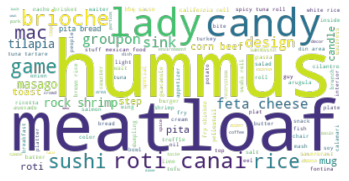

In [40]:
wc = WordCloud(background_color=None, mode="RGBA")
wc.generate_from_frequencies(user_importance[selected_user])
plt.imshow(wc, interpolation="bilinear")
plt.axis('off')
plt.show()

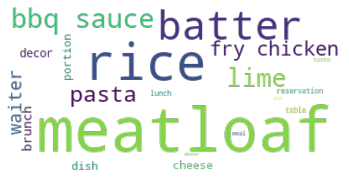

In [41]:
wc = WordCloud(background_color=None, mode="RGBA")
wc.generate_from_frequencies(analyseScores(user_restaurant_rs_scores_3[selected_user][top5_restaurant[0]][1]))
plt.imshow(wc, interpolation="bilinear")
plt.axis('off')
plt.show()

Positive reviews about the aspect

In [122]:
getReviewWithAspect(top5_restaurant[0], 'meatloaf')[0]

,review_id,user_id,business_id,stars,useful,funny,cool,text,date,aspect_polarity
4158,Xs2tdKVFPOSHJfd1N78-WA,oaz_EWwPSY3V8xofcXfsdA,pXRrRf8fDv6yU3xp1E25hA,5,2,0,0,This place rocks! I have been here 4 times now...,2019-09-10 00:59:12,"[{'aspect': ['place'], 'sentiment': ['Positive..."
4176,343_g6eZT3p6FKwAXYpNyA,okPC6jSaVJEtbScW3cihFg,pXRrRf8fDv6yU3xp1E25hA,5,0,0,0,Bud & Marilyns has been on my Philadelphia foo...,2020-01-07 01:53:13,"[{'aspect': ['food'], 'sentiment': ['Positive'..."


Neutral reviews about the aspect

In [130]:
getReviewWithAspect(top5_restaurant[0], 'meatloaf')[1]

,review_id,user_id,business_id,stars,useful,funny,cool,text,date,aspect_polarity
4172,VAUgBwQPkCDKdHpXrtopoQ,5GJ5aLTtTjGIiBz7i9GssQ,pXRrRf8fDv6yU3xp1E25hA,5,5,6,3,I'm in love. This was one of the best meals I'...,2015-11-05 15:53:05,"[{'aspect': [], 'sentiment': []}, {'aspect': [..."


Negative reviews about the aspect

In [126]:
getReviewWithAspect(top5_restaurant[0], 'meatloaf')[2]

,review_id,user_id,business_id,stars,useful,funny,cool,text,date,aspect_polarity


- Manually check whether aspect appear in the test set.
- Diagram to explain the argumentation
- Combine different argumentation schemes to create a restaurant recommendation argumentation scheme

### Evaluation

#### Evaluation of aspects

In [31]:
def restaurantTopKAspects(rid, k):
    get_aspect = lambda x: x[0];
    topk_items = sorted(restaurant_aspects[rid].items(), key=lambda x: x[1][0], reverse=True)[:k];
    aspects = [get_aspect(item) for item in topk_items];
    return aspects;

def userTop10Aspects(uid, k):
    return list(user_importance[uid].keys())[:k];

In [32]:
aspects_accuracy = []
for k in range(1, 11):
    user_accuracy = []
    for uid in user_ids:
        accuracy_5 = []
        u_topK = userTop10Aspects(uid, k)
        rids = list(user_restaurant_rs_scores[uid].keys())[:5]
        for rid in rids:
            count, r_topK = 0, restaurantTopKAspects(rid, k)
            for aspect in r_topK:
                if aspect in u_topK:
                    count += 1
            accuracy_5.append(count/k)
        user_accuracy.append(accuracy_5)
    aspects_accuracy.append(user_accuracy)

In [33]:
for k in range(1, 11):
    print('K=', k)
    r1_res, r2_res, r3_res, r4_res, r5_res = np.average([user_accuracy[0] for user_accuracy in aspects_accuracy[k-1]]), np.average([user_accuracy[1] for user_accuracy in aspects_accuracy[k-1]]), np.average([user_accuracy[2] for user_accuracy in aspects_accuracy[k-1]]), np.average([user_accuracy[3] for user_accuracy in aspects_accuracy[k-1]]), np.average([user_accuracy[4] for user_accuracy in aspects_accuracy[k-1]])
    print("Restautarant accuracy: top1 ", r1_res, "; top2 ", r2_res, "; top3", r3_res, "; top4", r4_res, "; top5", r5_res)

K= 1
Restautarant accuracy: top1  0.18 ; top2  0.14 ; top3 0.07 ; top4 0.09 ; top5 0.01
K= 2
Restautarant accuracy: top1  0.13 ; top2  0.11 ; top3 0.08 ; top4 0.075 ; top5 0.05
K= 3
Restautarant accuracy: top1  0.10333333333333332 ; top2  0.10333333333333332 ; top3 0.07333333333333333 ; top4 0.056666666666666664 ; top5 0.04666666666666666
K= 4
Restautarant accuracy: top1  0.0875 ; top2  0.0875 ; top3 0.0625 ; top4 0.0525 ; top5 0.045
K= 5
Restautarant accuracy: top1  0.08399999999999999 ; top2  0.076 ; top3 0.064 ; top4 0.05800000000000001 ; top5 0.06
K= 6
Restautarant accuracy: top1  0.08166666666666667 ; top2  0.075 ; top3 0.065 ; top4 0.05166666666666666 ; top5 0.05833333333333333
K= 7
Restautarant accuracy: top1  0.07428571428571427 ; top2  0.06999999999999999 ; top3 0.05999999999999999 ; top4 0.04999999999999999 ; top5 0.05571428571428571
K= 8
Restautarant accuracy: top1  0.06875 ; top2  0.06375 ; top3 0.05625 ; top4 0.045 ; top5 0.0525
K= 9
Restautarant accuracy: top1  0.06333333

#### Evaluation of place  
- Coverage  
    - Coverage is the percent of items in the training data the model is able to recommend on a test set. 
    - For the evaluation of place, recommendated place/visited place, the result is not good
- MAP@k  
    - http://sdsawtelle.github.io/blog/output/mean-average-precision-MAP-for-recommender-systems.html  
    - https://towardsdatascience.com/evaluation-metrics-for-recommender-systems-df56c6611093  
    MAP@k is somehow useless for this project, since we merely have negative reviews

- Precision@K
- Recall@K
- F1@K

In [34]:
total_count = 0
min_test_size = float('inf');
for uid in users_test:
    min_test_size = min_test_size if users_test[uid].size > min_test_size else users_test[uid].size
    total_count += users_test[uid].size
    
def precision_K(recommend_scores, k):
    TP = 0;
    for uid in user_ids:
        for rid in list(recommend_scores[uid].keys())[:k]:
            if rid in users_test[uid]:
                TP += 1
    return TP/(k*user_ids.size)

#  OR Coverage
def recall_K(recommend_scores, k):
    TP = 0;
    for uid in user_ids:
        for rid in list(recommend_scores[uid].keys())[:k]:
            if rid in users_test[uid]:
                TP += 1
    return TP/total_count

def F1_K(recommend_scores, k):
    precision, recall = precision_K(recommend_scores, k), recall_K(recommend_scores, k)
    return 2*precision*recall/(precision+recall)

In [35]:
precisions, recalls, f1s = [], [], []

for i in range(1, 11):
    precisions.append(precision_K(user_restaurant_rs_scores_3, i))
    recalls.append(recall_K(user_restaurant_rs_scores_3, i))
    f1s.append(F1_K(user_restaurant_rs_scores_3, i))

In [36]:
import matplotlib.pyplot as plt

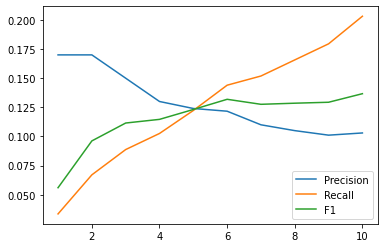

In [37]:
plt.plot(range(1, 11), precisions, label="Precision")
plt.plot(range(1, 11), recalls, label="Recall")
plt.plot(range(1, 11), f1s, label="F1")
plt.legend()

In [41]:
print('Precision:', precisions)
print('Recall:', recalls)
print('F1s:', f1s)

Precision: [0.17, 0.17, 0.15, 0.13, 0.124, 0.12166666666666667, 0.11, 0.105, 0.10111111111111111, 0.103]
Recall: [0.03353057199211045, 0.0670611439842209, 0.08875739644970414, 0.10256410256410256, 0.1222879684418146, 0.14398422090729784, 0.15187376725838264, 0.16568047337278108, 0.1794871794871795, 0.20315581854043394]
F1s: [0.05601317957166392, 0.09618104667609619, 0.11152416356877323, 0.11466372657111357, 0.12313803376365441, 0.13188798554652217, 0.12758906379453192, 0.1285386381025249, 0.12935323383084577, 0.1366954213669542]


In [52]:
print('CF Precision:', cf_precisions)
print('CF Recall:', cf_recalls)
print('CF F1s:', cf_f1)

CF Precision: [0.12, 0.09, 0.07333333333333333, 0.075, 0.09, 0.08166666666666667, 0.08571428571428572, 0.09, 0.09222222222222222, 0.091]
CF Recall: [0.023668639053254437, 0.03550295857988166, 0.04339250493096647, 0.05917159763313609, 0.08875739644970414, 0.09664694280078895, 0.11834319526627218, 0.14201183431952663, 0.16370808678500987, 0.1794871794871795]
CF F1s: [0.039538714991762765, 0.05091937765205093, 0.05452292441140025, 0.0661521499448732, 0.08937437934458789, 0.08852755194218609, 0.09942004971002485, 0.11017597551644989, 0.1179815209665956, 0.1207697412076974]


Coverage

In [38]:
count = 0
for uid in user_ids:
    for rid in list(user_restaurant_rs_scores_3[uid].keys())[:users_test[uid].size]:
        if rid in users_test[uid]:
            count += 1
count/total_count

0.1301775147928994

### Baseline traditional CF-RS

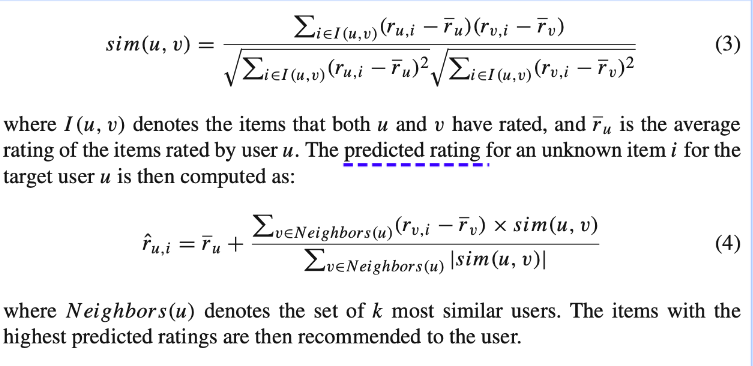

In [42]:
from numpy.linalg import norm;

In [43]:
restaurant_ids = restaurants['business_id'].unique();

In [44]:
def userRestaurantToVector(uid):
    visited_rids = users_visited[uid];
    vector = np.zeros(restaurant_ids.size, dtype='float');
    for visited_rid in visited_rids:
        index = np.where(restaurant_ids==visited_rid)[0][0];
        score = np.average(users_train.groupby(['user_id', 'business_id']).get_group((uid, visited_rid))['stars'].values);
        vector[index] = score;
    return vector;

In [45]:
user_rvector_matrix = np.array([userRestaurantToVector(uid) for uid in user_ids]);
user_similarity_matric = np.array([np.dot(user_rvector_matrix, user_rvector_matrix[i])/(norm(user_rvector_matrix, axis=1)*norm(user_rvector_matrix[i])) for i in range(100)]);

In [46]:
def getAverageScoreOf(uid):
    return np.average(users_train.groupby('user_id').get_group(uid)['stars'].values);

def getTop10NeighborsWithScore(vector):
    simialr_users = dict(zip(user_ids, vector));
    simialr_users = sorted(simialr_users.items(), key=lambda x: x[1], reverse=True);
    top_10_neighbors = list(simialr_users)[1:11];
    return top_10_neighbors;

def recommendScoreOf(uid, vector):
    top_10_neighbors = getTop10NeighborsWithScore(vector);
    avg_score_u = getAverageScoreOf(uid);
    rids = set(restaurant_ids).difference(set(users_visited[uid])); # Get the restaurants that haven't been visited by user u
    scores = {}
    
    for rid in rids:
        r_index = list(restaurant_ids).index(rid);
        numerator, denominator = 0, 0;
        for vid, similarity in top_10_neighbors:
            v_visited = users_visited[vid];
            v_index = list(user_ids).index(vid);
            if rid in v_visited:
                avg_score_v = getAverageScoreOf(vid);
                v_r_score = user_rvector_matrix[v_index][r_index];
                numerator += similarity*(v_r_score-avg_score_v);
                denominator += abs(similarity);
        scores[rid] = avg_score_u+(numerator/denominator) if denominator else 0; # 0 represents i doesn't appear in any of the neighbours's history
    
    return scores;

Coverage

In [47]:
count = 0;

for i, uid in enumerate(user_ids):
    recommend_ids = [rid for rid, score in sorted(recommendScoreOf(uid, user_similarity_matric[i]).items(), key=lambda x: x[1], reverse=True)][:users_test[uid].size];
    for rid in recommend_ids:
        if rid in users_test[uid]:
            count += 1;

total_count = 0;
for uid in users_test:
    total_count += users_test[uid].size;

In [48]:
count/total_count

0.10059171597633136

In [49]:
def precision_K(k):
    TP = 0;
    for i, uid in enumerate(user_ids):
        recommend_ids = [rid for rid, score in sorted(recommendScoreOf(uid, user_similarity_matric[i]).items(), key=lambda x: x[1], reverse=True)][:k];
        for rid in recommend_ids:
            if rid in users_test[uid]:
                TP += 1;
    return TP/(k*user_ids.size)

def recall_K(k):
    TP = 0;
    for i, uid in enumerate(user_ids):
        recommend_ids = [rid for rid, score in sorted(recommendScoreOf(uid, user_similarity_matric[i]).items(), key=lambda x: x[1], reverse=True)][:k];
        for rid in recommend_ids:
            if rid in users_test[uid]:
                TP += 1;
    return TP/total_count

def F1_K(k):
    precision, recall = precision_K(k), recall_K(k)
    return 2*precision*recall/(precision+recall)

In [50]:
from tqdm import tqdm
cf_precisions, cf_recalls, cf_f1 = [], [], []

for i in tqdm(range(1, 11)):
    cf_precisions.append(precision_K(i))
    cf_recalls.append(recall_K(i))
    cf_f1.append(F1_K(i))

100%|██████████| 10/10 [11:36<00:00, 69.69s/it]


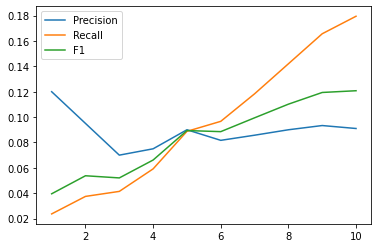

In [88]:
plt.plot(range(1, 11), cf_precisions, label="Precision")
plt.plot(range(1, 11), cf_recalls, label="Recall")
plt.plot(range(1, 11), cf_f1, label="F1")
plt.legend()